[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" width = 500 align="left">](https://www.gov.br/inpe/pt-br)

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 300 align="right">](http://www.inpe.br/posgraduacao/cap/)

<div style="text-align: center;font-size: 90%;">
<h1 style="color:#336699;">Datasets de imagens com diferentes resoluções espaciais</h1>
</div>
<hr style="border:2px solid #0077b9;">


<br/>

<div style="text-align: center;font-size: 90%;">
    <strong>Lourenço José Cavalcante Neto</strong><sup><a href="https://orcid.org/0000-0001-6181-2158"><i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>
    <br/>
    Programa de Pós-graduação em Computação Aplicada, Instituto Nacional de Pesquisas Espaciais (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/>
    E-mail: <a href="mailto:lourenco.cavalante@ifto.edu.br">lourenco.cavalante@ifto.edu.br</a>
    <br/><br/>
    <strong>Gisele Mota</strong><sup><a href="#"><i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>
    <br/>
    Programa de Pós-graduação em Computação Aplicada, Instituto Nacional de Pesquisas Espaciais (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/>
    E-mail: <a href="mailto:giselemmota@gmail.com">giselemmota@gmail.com</a>
    <br/><br/>
    Entregue em: 25 de Maio de 2025
</div>

<br/>

<div style="text-align: justify;  margin-left: 10%; margin-right: 10%;">
<b>Resumo: </b> Este Jupyter Notebook é parte do projeto final da disciplina Introdução à Programação com Dados Geoespaciais. O objetivo foi colocar em prática os conhecimentos adquiridos ao longo da disciplina, por meio da exploração e processamento de dados obtidos por sensores a bordo do satélite CBERS-4A, disponibilizados via serviço STAC (SpatioTemporal Asset Catalog). O projeto parte da ideia de que diferentes sensores — WFI, MUX e WPM — observam, ao mesmo tempo, as mesmas regiões da superfície terrestre, porém com diferentes resoluções espaciais. Isso permite investigar como essas variações de resolução afetam a forma como os alvos são representados nas imagens. Em linhas gerais, este trabalho consistiu em selecionar 4 cenas adquiridas na mesma data por esses três sensores e, a partir delas, foram gerados vários recortes (patches) geograficamente alinhados, contendo 4 bandas por sensor. Esses patches formaram um banco de dados multiresolução, que eventualmente poderá ser usado em testes com modelos de classificação baseados em Deep Learning. Por fim, o notebook apresenta gráficos e visualizações comparativas que evidenciam as semelhanças e diferenças entre as imagens em diferentes resoluções, contribuindo para a análise e compreensão dos dados geoespaciais no contexto da inteligência artificial.
</div>    

<br/>

In [109]:
#!pip install --upgrade pip

In [ ]:
#Instalação das bibliotecas necessárias, caso ainda nas as tenha no seu  ambiente

!pip install pystac-client rasterio shapely matplotlib rioxarray geopandas ipyleaflet folium

### Importações principais para manipulação geoespacial, visualização e processamento


In [1]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
import geopandas as gpd
import shapely
from shapely.geometry import box
from shapely.geometry import mapping
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import rioxarray as rxr
from collections import defaultdict
from datetime import datetime
import itertools

import folium


print("Execução concluída.")

Execução concluída.


## Vamos usar o serviço STAC (SpatioTemporal Asset Catalog)  do Brazil Data Cube para descobrir e acessar os dados do CBERS-A4, nos quais serão usados nas próximas etapas do Projeto
O **STAC** é uma especificação criada por meio da colaboração de diversas organizações com o objetivo de aumentar a interoperabilidade da pesquisa de imagens de satélite.

In [2]:
import pystac_client

print(f'Versão do STAC: {pystac_client.__version__}\n')

#Aqui criamos um objeto STAC anexado ao serviço STAC do Brazil Data Cube, que chamaremos de "catalogo".
catalogo = pystac_client.Client.open("https://data.inpe.br/bdc/stac/v1/")
catalogo

Versão do STAC: 0.8.5



<Client id=INPE>

## Não listamos todas as coleções de imagens e cubos de dados disponíveis. Concentramos nossos esforçoes em descobrir e acessar os dados do CBERS-A4, especificamente dos sensores que temos interesse, sendo eles: WPM, MUX e WFI.

O sensor **WPM (*Wide Scan Panchromatic and Multispectral Camera*)** a bordo do CBERS-4A realiza o imageamento da superfície terrestre usando um swath de 92km x 92km com resolução temporal de 31 dias e produz imagens de 10 bits. Já o sensor **MUX (*Regular Multispectral Camera*)** realiza o imageamento da superfície terrestre com um swath de 95km x 95km com resolução temporal de 31 dias e produz imagens de 8 bits. O sensor **WFI (*Wide Field Imaging Camera*)** realiza o imageamento da superfície terrestre em um swath de 684km x 684km. Sua órbita foi projetada para proporcionar uma alta taxa de revisita, de 5 dias, e produz imagens de 10 bits.

In [3]:
# Vamos percorrer todas as coleções disponíveis no catálogo usando um "for"
for colecao in catalogo.get_collections():
    
    # Pegamos o título da coleção atual para facilitar o filtro
    titulo = colecao.title
    
    # Verificamos se essa coleção é do satélite CBERS-4A 
    # e se ela corresponde a um dos três sensores de interesse: WFI, MUX ou WPM
    if "CBERS-4A" in titulo and ("WFI" in titulo or "MUX" in titulo or "WPM" in titulo):
        
        # Se a condição for atendida (verdadeira), mostramos o ID e o título da coleção
        print(f"{colecao.id}: {titulo}")


mosaic-cbers4a-paraiba-3m-1: CBERS-4A/WFI Image Mosaic of Brazil Paraíba State - 3 Months
CB4A-WFI-L2-DN-1: CBERS-4A/WFI - Level-2-DN
CB4A-WFI-L4-DN-1: CBERS-4A/WFI - Level-4-DN
CB4A-MUX-L2-DN-1: CBERS-4A/MUX - Level-2-DN
CB4A-WPM-L2-DN-1: CBERS-4A/WPM - Level-2-DN
CB4A-MUX-L4-DN-1: CBERS-4A/MUX - Level-4-DN
CB4A-WPM-L4-DN-1: CBERS-4A/WPM - Level-4-DN
CB4A-WFI-L4-SR-1: CBERS-4A/WFI - Level-4-SR - Cloud Optimized GeoTIFF
CB4A-WPM-PCA-FUSED-1: CBERS-4A/WPM - Multispectral and Panchromatic Bands Fusioned


Utilizamos o método collection para acessar informações referente às coleções **CB4A-WFI-L4-DN-1**, **CB4A-MUX-L4-DN-1** e **CB4A-WPM-L4-DN-1**. Assim como fizemos no código abaixo, em que acessamos as informações da coleção **CB4A-WFI-L4-DN-1**, o mesmo procedimento pode ser utilizado para as demais coleções. Optamos por usar do Level 4, pois elas são as mais procuradas e estão prontas para uso, sem necessidade de procedimentos adicionais por parte dos usuários.

In [4]:
# Com base nas visualizações acima, vamos definir as coleções do CBERS-4A  que temos interesse

colecoes_alvo = ['CB4A-WFI-L4-DN-1','CB4A-MUX-L4-DN-1','CB4A-WPM-L4-DN-1']

# Utilizamos o método collection para acessar informações referente às coleções
# CB4A-WFI-L4-DN-1, CB4A-MUX-L4-DN-1 e CB4A-WPM-L4-DN-1. Assim como fizemos no código abaixo,
# em que acessamos as informações da coleção CB4A-WFI-L4-DN-1, o mesmo procedimento pode ser utilizado para as demais coleções.


for id_collection in colecoes_alvo:
    collection = catalogo.get_collection(id_collection)
    
    print(f"\n{'='*40}")
    print(f"ID: {collection.id}")
    print(f"Título: {collection.title}")
    print(f"Descrição: {collection.description}")




ID: CB4A-WFI-L4-DN-1
Título: CBERS-4A/WFI - Level-4-DN
Descrição: CBERS-4A/WFI Level-4 Digital Number product. L4 product provides orthorectified images.

ID: CB4A-MUX-L4-DN-1
Título: CBERS-4A/MUX - Level-4-DN
Descrição: CBERS-4A/MUX - Level-4 Digital Number product. L4 product provides orthorectified images.

ID: CB4A-WPM-L4-DN-1
Título: CBERS-4A/WPM - Level-4-DN
Descrição: CBERS-4A/WPM - Level-4 Digital Number product. L4 product provides orthorectified images.


## Aqui definimos o polígono da região de interesse  (MT) para consulta por coleções disponíveis na região escolhida

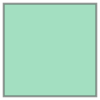

In [5]:
regiao_interesse_UF_MT =  shapely.geometry.shape({
    "type": "Polygon",
    "coordinates": [[
        [-61.0, -18.0],  # canto inferior esquerdo
        [-61.0, -7.0],   # canto superior esquerdo
        [-50.0, -7.0],   # canto superior direito
        [-50.0, -18.0],  # canto inferior direito
        [-61.0, -18.0]   # fechar o polígono
    ]]
})

regiao_interesse_UF_MT



## Criação de mapa interativo com destaque para a região de interesse (Mato Grosso) usando o FOLIUM
 (Executar esta célula se o ambiente for o **Kaggle**)

In [6]:
# Converter a geometria (região de interesse) para o formato GeoJSON
geojson_data = mapping(regiao_interesse_UF_MT)

# Criar o mapa centralizado no centro da geometria
centro = [regiao_interesse_UF_MT.centroid.y, regiao_interesse_UF_MT.centroid.x]

mapa = folium.Map(
    location=centro,
    zoom_start=4,
    control_scale=True,
    width='50%',
    height='300px'
)

# Adicionar a camada GeoJSON ao mapa com o estilo
folium.GeoJson(
    geojson_data,
    name="Região de Interesse",
    style_function=lambda x: {
        'color': 'SteelBlue',
        'weight': 5,
        'fillOpacity': 0.1
    },
    highlight_function=lambda x: {
        'color': 'IndianRed',
        'weight': 5,
        'fillOpacity': 0.1
    }
).add_to(mapa)

# Controles de camadas
folium.LayerControl().add_to(mapa)

# Exibir mapa com o retângulo
mapa


# Definir/recortar e mostrar região alvo para verificação

In [7]:
# --- 1. Busca e extração das datas em comum ---

resultados = {}
datas_por_colecao = defaultdict(list)

for colecao in colecoes_alvo:
    item_search = catalogo.search(
        collections=[colecao],
        datetime='2019-01-01/2025-05-05',
        intersects=shapely.geometry.mapping(regiao_interesse_UF_MT),
        # query={
        #     "eo:cloud_cover": {
        #         "lt": 0.6
        #     }
        # }
    )

    itens = list(item_search.items())
    resultados[colecao] = itens

    print(f"--> {len(itens)} cenas encontradas para {colecao}")
    
    for item in itens:
        
        data = item.properties['datetime'][:10]
        datas_por_colecao[colecao].append((data, item.id))

datas_em_comum = set.intersection(*[set([d for d, _ in datas]) for datas in datas_por_colecao.values()])

print("\nItens com datas em comum entre as coleções:\n")
for data in sorted(datas_em_comum):
    print(f"\n{data}:")
    for colecao in colecoes_alvo:
        itens = [item_id for d, item_id in datas_por_colecao[colecao] if d == data]
       
        for item_id in itens:
            print(f"  - {colecao}: {item_id}")


--> 22 cenas encontradas para CB4A-WFI-L4-DN-1
--> 21 cenas encontradas para CB4A-MUX-L4-DN-1
--> 22 cenas encontradas para CB4A-WPM-L4-DN-1

Itens com datas em comum entre as coleções:


2024-11-08:
  - CB4A-WFI-L4-DN-1: CBERS_4A_WFI_RAW_20241108_219_124_L4
  - CB4A-MUX-L4-DN-1: CBERS_4A_MUX_RAW_20241108_219_126_L4
  - CB4A-MUX-L4-DN-1: CBERS_4A_MUX_RAW_20241108_219_125_L4
  - CB4A-WPM-L4-DN-1: CBERS_4A_WPM_RAW_20241108_219_125_L4

2024-11-17:
  - CB4A-WFI-L4-DN-1: CBERS_4A_WFI_RAW_20241117_211_124_L4
  - CB4A-WFI-L4-DN-1: CBERS_4A_WFI_RAW_20241117_211_140_L4
  - CB4A-MUX-L4-DN-1: CBERS_4A_MUX_RAW_20241117_211_125_L4
  - CB4A-MUX-L4-DN-1: CBERS_4A_MUX_RAW_20241117_211_128_L4
  - CB4A-MUX-L4-DN-1: CBERS_4A_MUX_RAW_20241117_211_129_L4
  - CB4A-WPM-L4-DN-1: CBERS_4A_WPM_RAW_20241117_211_126_L4
  - CB4A-WPM-L4-DN-1: CBERS_4A_WPM_RAW_20241117_211_125_L4
  - CB4A-WPM-L4-DN-1: CBERS_4A_WPM_RAW_20241117_211_127_L4
  - CB4A-WPM-L4-DN-1: CBERS_4A_WPM_RAW_20241117_211_129_L4

2024-11-18:
  - CB4

## Verificação das bandas disponíveis para (WFI, MUX, WPM)


In [8]:
bandas_disponiveis_por_colecao = {}

for colecao in colecoes_alvo:
    busca_bandas = catalogo.search(
        collections=[colecao],
        datetime='2019-01-01/2025-05-05',
        intersects=shapely.geometry.mapping(regiao_interesse_UF_MT),
    )
    
    bandas_disponiveis_por_colecao[colecao] = list(busca_bandas.items())

    # Verificação do número de itens encontrados
    print(f"--> Bandas disponíveis para {colecao}:")
    
    # Vamos limitar ao resultado para cada, usando o parâmetro 1 em islice
    for item in itertools.islice(busca_bandas.items(), 1):
        # print(f"{item.id}")
        # print(f"{item.properties['datetime']}")
        for nome_banda in item.assets.keys():
            print(f"    - {nome_banda}")

    print("\n")


--> Bandas disponíveis para CB4A-WFI-L4-DN-1:
    - BAND13
    - BAND14
    - BAND15
    - BAND16
    - thumbnail
    - BAND13_xml
    - BAND14_xml
    - BAND15_xml
    - BAND16_xml


--> Bandas disponíveis para CB4A-MUX-L4-DN-1:
    - BAND5
    - BAND6
    - BAND7
    - BAND8
    - BAND5_xml
    - BAND6_xml
    - BAND7_xml
    - BAND8_xml
    - thumbnail


--> Bandas disponíveis para CB4A-WPM-L4-DN-1:
    - BAND0
    - BAND1
    - BAND2
    - BAND3
    - BAND4
    - BAND0_xml
    - BAND1_xml
    - BAND2_xml
    - BAND3_xml
    - BAND4_xml
    - thumbnail




## Seleção manual de cenas por sensor e listagem das Bandas de cada um

In [9]:
#De acordo com as datas com cenas listadas no código anterior, aqui podemos escolhar a DATA e a CENA 

data_alvo = "2024-11-23"

selecionados = {
    'CB4A-WFI-L4-DN-1': 'CBERS_4A_WFI_RAW_20241123_216_124_L4',
    'CB4A-MUX-L4-DN-1': 'CBERS_4A_MUX_RAW_20241123_216_122_L4',
    'CB4A-WPM-L4-DN-1': 'CBERS_4A_WPM_RAW_20241123_216_122_L4',
}


colecoes_alvo_bandas = {
    'CB4A-WFI-L4-DN-1': ['BAND13', 'BAND14', 'BAND15', 'BAND16'],
    'CB4A-MUX-L4-DN-1': ['BAND5', 'BAND6', 'BAND7', 'BAND8'],
    'CB4A-WPM-L4-DN-1': ['BAND1', 'BAND2', 'BAND3', 'BAND4']
}

assets_por_colecao = {}

for col_id, bandas in colecoes_alvo_bandas.items():
    item_encontrado = None
    for item in resultados[col_id]:
        if item.id == selecionados[col_id]:
            item_encontrado = item
            break
    if item_encontrado:
        assets = {banda: item_encontrado.assets[banda].href for banda in bandas}
        assets_por_colecao[col_id] = assets
        print(f"{col_id}: {item_encontrado.id}")

        
    else:
        print(f"{col_id} não possui item com ID {selecionados[col_id]}")

CB4A-WFI-L4-DN-1: CBERS_4A_WFI_RAW_20241123_216_124_L4
CB4A-MUX-L4-DN-1: CBERS_4A_MUX_RAW_20241123_216_122_L4
CB4A-WPM-L4-DN-1: CBERS_4A_WPM_RAW_20241123_216_122_L4


In [35]:
# Funções auxiliares para recorte, bbox, visualização e salvação ---
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def obter_bbox_wpm(href, proporcao=0.1, deslocamento_x=0.0, deslocamento_y=0.0):
    with rasterio.open(href) as src:
        minx, miny, maxx, maxy = src.bounds
        largura_total = maxx - minx
        altura_total = maxy - miny
        largura = largura_total * proporcao
        altura = altura_total * proporcao
        x0 = minx + largura_total * deslocamento_x
        y0 = miny + altura_total * deslocamento_y
        return (x0, y0, x0 + largura, y0 + altura)

def recortar_patch(href, bbox, target_shape=None):
    with rasterio.open(href) as src:
        window = src.window(*bbox)
        if window.width <= 0 or window.height <= 0:
            raise ValueError(f"Recorte fora da imagem: {href}")
        transform = src.window_transform(window)
        data = src.read(1, window=window, out_shape=target_shape, resampling=Resampling.bilinear if target_shape else Resampling.nearest)
        if data.size == 0 or np.mean(data) < 1e-5:
            raise ValueError(f"Recorte sem dados válidos: {href}")
        # return normalize(data), transform
        return data, transform

def mostrar_bbox_sobre_imagem(href, bbox):
    with rasterio.open(href) as src:
        img = src.read(1)
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        plt.imshow(img, extent=extent, cmap='gray')
        x0, y0, x1, y1 = bbox
        plt.gca().add_patch(Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, edgecolor='red', linewidth=2))
        plt.title("Região de interesse (Recorte)")
        plt.show()

def salvar_patch_tif(array, transform, crs, path_saida):
    if array.ndim == 2:
        array = array[np.newaxis, :, :]
    else:
        array = np.moveaxis(array, -1, 0)
    with rasterio.open(path_saida, 'w', driver='GTiff',
                       height=array.shape[1], width=array.shape[2],
                       count=array.shape[0], dtype=array.dtype,
                       crs=crs, transform=transform) as dst:
        dst.write(array)

def gerar_patches(assets_por_colecao, bandas_rgb, bbox, path_saida_base='patches_wfi_mux_wpm_cbers4a'):
    os.makedirs(path_saida_base, exist_ok=True)
    patches_rgb = {}

    for colecao, bandas in bandas_rgbnir.items():
        hrefs = [assets_por_colecao[colecao][b] for b in bandas]
        rgbnir_bandas = []
    
        for href in hrefs:
            with rasterio.open(href) as src:
                crs = src.crs
            patch, transform = recortar_patch(href, bbox)
            rgbnir_bandas.append(patch)
    
        # array_rgbnir = np.dstack(rgbnir_bandas)
        # patch_rgb = normalize(array_rgbnir)
        # patches_rgb[colecao] = patch_rgb


        array_rgbnir = np.dstack(rgbnir_bandas)
        patches_rgb[colecao] = array_rgbnir
    
        # --- Salvamento com nome personalizado por coleção ---
        if colecao == "CB4A-WFI-L4-DN-1":
            nome_arquivo = "CB4A_WFI_L4_DN_1_20251123_55MT.tif"
        elif colecao == "CB4A-MUX-L4-DN-1":
            nome_arquivo = "CB4A_MUX_L4_DN_1_20251123_16MT.tif"
        elif colecao == "CB4A-WPM-L4-DN-1":
            nome_arquivo = "CB4A_WPM_L4_DN_1_20251123_8MT.tif"
        else:
            nome_arquivo = f"{colecao.replace('-', '_')}_patch.tif"
    
        salvar_patch_tif(array_rgbnir, transform, crs, os.path.join(path_saida_base, nome_arquivo))

    return patches_rgb

def mostrar_patches_rgb(patches_rgb, data_alvo):
    fig, axes = plt.subplots(1, len(patches_rgb), figsize=(18, 6), dpi=300)
    for ax, (colecao, img) in zip(axes, patches_rgb.items()):
        # Seleciona apenas as 3 primeiras bandas para exibição
        ax.imshow(img[:, :, :3])
        ax.set_title(f"{colecao}\n{data_alvo}", fontsize=12)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


print(f"Funções definidas com sucesso.")

Funções definidas com sucesso.


## Visualização das bandas NIR dos itens selecionados 

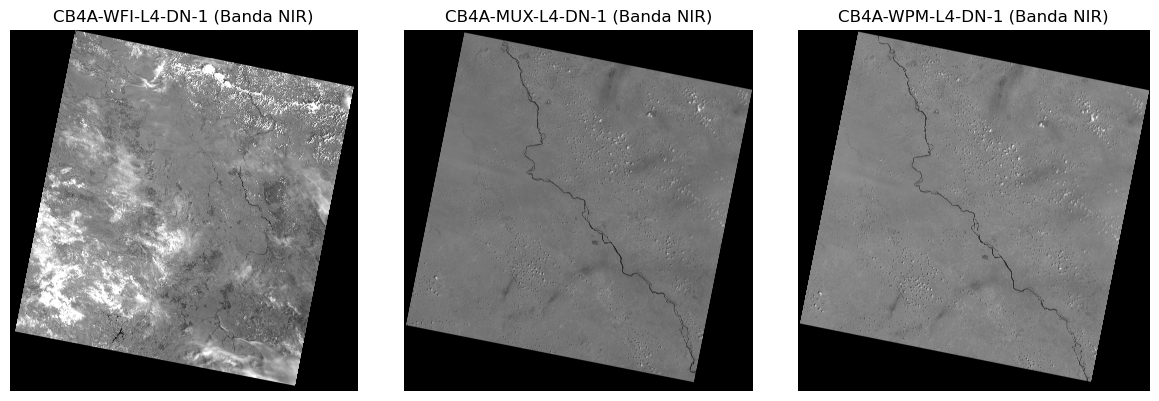

In [11]:
with rasterio.open(assets_por_colecao['CB4A-WFI-L4-DN-1']['BAND16']) as banda:
    nir_band_wfi = banda.read(1)
with rasterio.open(assets_por_colecao['CB4A-MUX-L4-DN-1']['BAND8']) as banda:
    nir_band_mux = banda.read(1)
with rasterio.open(assets_por_colecao['CB4A-WPM-L4-DN-1']['BAND4']) as banda:
    nir_band_wpm = banda.read(1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.set_title(f"CB4A-WFI-L4-DN-1 (Banda NIR)")
ax1.imshow(nir_band_wfi, cmap='gray')
ax1.axis('off')
ax2.set_title(f"CB4A-MUX-L4-DN-1 (Banda NIR)")
ax2.imshow(nir_band_mux, cmap='gray')
ax2.axis('off')
ax3.set_title(f"CB4A-WPM-L4-DN-1 (Banda NIR)")
ax3.imshow(nir_band_wpm, cmap='gray')
ax3.axis('off')
plt.tight_layout()
plt.savefig(f"nir_band_wfi_mux_wpm_.png", dpi=300)
plt.show()

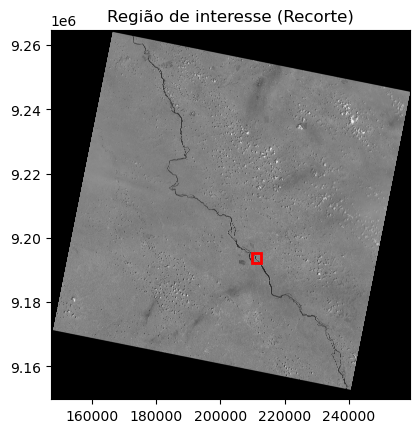

In [58]:
# --- 5. Gerar BBOX com base no WPM ---
bbox = obter_bbox_wpm(
    href=assets_por_colecao['CB4A-WPM-L4-DN-1']['BAND4'],
    proporcao=0.025,
    deslocamento_x=0.56,
    deslocamento_y=0.37
)
mostrar_bbox_sobre_imagem(assets_por_colecao['CB4A-WPM-L4-DN-1']['BAND4'], bbox)


# --- 6. Definir bandas RGB+NIR e gerar patches ---
bandas_rgbnir = {
    'CB4A-WFI-L4-DN-1': ['BAND13', 'BAND14', 'BAND15', 'BAND16'],  # B, G, R, NIR
    'CB4A-MUX-L4-DN-1': ['BAND5', 'BAND6', 'BAND7', 'BAND8'],   # B, G, R, NIR
    'CB4A-WPM-L4-DN-1': ['BAND1', 'BAND2', 'BAND3', 'BAND4']   # B, G, R, NIR
}


patches_rgb = gerar_patches(assets_por_colecao, bandas_rgbnir, bbox)
# mostrar_patches_rgb(patches_rgb, data_alvo)

## Outros fluxos de códigos

In [26]:
# import rasterio as rio
# dataset1 = rio.open('patches_wfi_mux_wpm_cbers4a/CB4A_WPM_L4_DN_1_20251123_8MT.tif')
# dataset1.indexes
# dataset1.crs

/tmp/ipykernel_288/3777389649.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


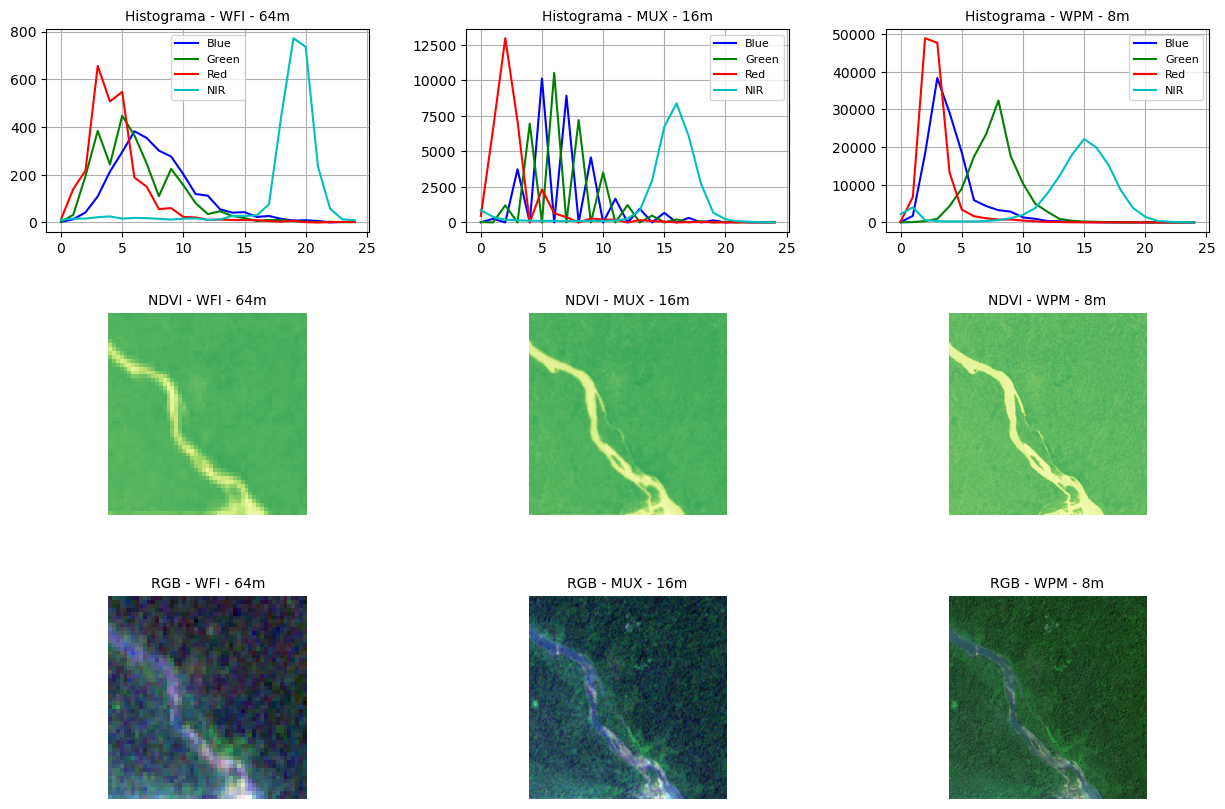

In [65]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min))

arquivos = [
    "patches_wfi_mux_wpm_cbers4a/CB4A_WFI_L4_DN_1_20251123_55MT.tif",
    "patches_wfi_mux_wpm_cbers4a/CB4A_MUX_L4_DN_1_20251123_16MT.tif",
    "patches_wfi_mux_wpm_cbers4a/CB4A_WPM_L4_DN_1_20251123_8MT.tif"
]
nomes = ["WFI - 64m", "MUX - 16m", "WPM - 8m"]

fig, axes = plt.subplots(3, 3, figsize=(15, 10), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

for i, (arquivo, nome) in enumerate(zip(arquivos, nomes)):
    ds = gdal.Open(arquivo, gdal.GA_ReadOnly)
    blue = ds.GetRasterBand(1).ReadAsArray()
    green = ds.GetRasterBand(2).ReadAsArray()
    red = ds.GetRasterBand(3).ReadAsArray()
    nir = ds.GetRasterBand(4).ReadAsArray()

    # Normalizar bandas
    blue_n = normalize(blue)
    green_n = normalize(green)
    red_n = normalize(red)
    nir_n = normalize(nir)

    # --- 1. Histogramas
    axes[0, i].plot(np.histogram(blue_n, bins=25, range=(0, 1))[0], 'b', label='Blue')
    axes[0, i].plot(np.histogram(green_n, bins=25, range=(0, 1))[0], 'g', label='Green')
    axes[0, i].plot(np.histogram(red_n, bins=25, range=(0, 1))[0], 'r', label='Red')
    axes[0, i].plot(np.histogram(nir_n, bins=25, range=(0, 1))[0], 'c', label='NIR')
    axes[0, i].set_title(f"Histograma - {nome}", fontsize=10)
    axes[0, i].grid(True)
    axes[0, i].legend(fontsize=8)

    # --- 2. NDVI
    np.seterr(divide='ignore', invalid='ignore')
    ndvi = (nir - red) / (nir + red + 0.0000000001)
    ndvi = np.clip(ndvi, -1, 1)
    axes[1, i].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[1, i].set_title(f"NDVI - {nome}", fontsize=10)
    axes[1, i].axis('off')

    # --- 3. RGB
    rgb = np.dstack((red_n, green_n, blue_n))
    axes[2, i].imshow(rgb)
    axes[2, i].set_title(f"RGB - {nome}", fontsize=10)
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


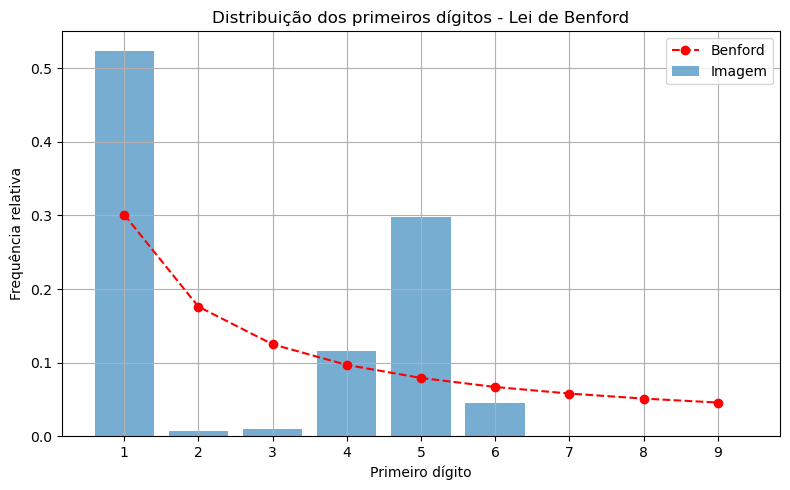

In [73]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import math

def first_digit(val):
    val = abs(val)
    while val >= 10:
        val //= 10
    while 0 < val < 1:
        val *= 10
    return int(val) if val > 0 else None

# Caminho da imagem (ex: WPM com 4 bandas)
arquivo = "patches_wfi_mux_wpm_cbers4a/CB4A_WPM_L4_DN_1_20251123_8MT.tif"
ds = gdal.Open(arquivo, gdal.GA_ReadOnly)

# Lê as bandas necessárias (Red = 3, NIR = 4)
red = ds.GetRasterBand(3).ReadAsArray()
nir = ds.GetRasterBand(4).ReadAsArray()

# Aplica a máscara para valores positivos
valores = np.concatenate([red.ravel(), nir.ravel()])
valores = valores[valores > 0]

# Calcula o primeiro dígito
digitos = [first_digit(v) for v in valores if first_digit(v) is not None]
total = len(digitos)

# Frequência observada
contagem = [digitos.count(d) for d in range(1, 10)]
proporcao_obs = [c / total for c in contagem]

# Frequência esperada (Benford)
benford_teorico = [math.log10(1 + 1/d) for d in range(1, 10)]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, 10), proporcao_obs, alpha=0.6, label='Imagem')
plt.plot(range(1, 10), benford_teorico, 'ro--', label='Benford')
plt.xticks(range(1, 10))
plt.title("Distribuição dos primeiros dígitos - Lei de Benford")
plt.xlabel("Primeiro dígito")
plt.ylabel("Frequência relativa")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


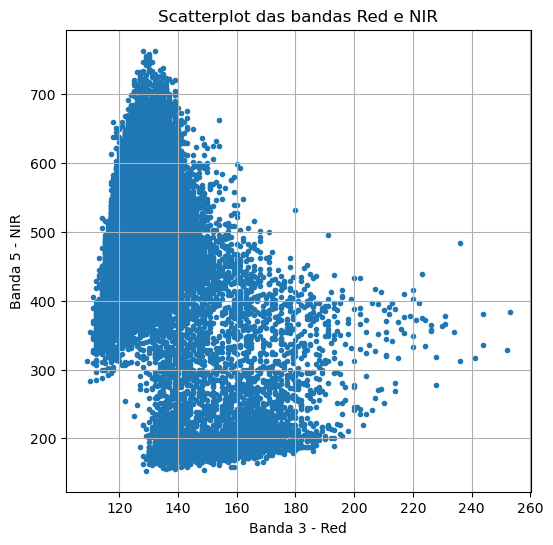

In [74]:
# obter os vetores de 1 dimensão de cada banda
vetor_red = red.flatten()
vetor_nir = nir.flatten()

# construir o gráfico com o scatterplot
plt.figure(figsize=(6, 6))

plt.scatter(vetor_red, vetor_nir, marker='.')
plt.xlabel("Banda 3 - Red")
plt.ylabel("Banda 5 - NIR")
plt.title("Scatterplot das bandas Red e NIR")
plt.grid();

In [80]:
# obter as matrizes de pixels de cada banda
blue = banda_blue.ReadAsArray()
green = banda_green.ReadAsArray()
red = banda_red.ReadAsArray()
nir = banda_nir.ReadAsArray()

# combinamos GDAL e Matplotlib para
# visualizar as bandas individualmente
plt.figure(figsize=(20, 5))
plt.subplot(151)
plt.imshow(blue, cmap='gray')
plt.title('Banda 1 - Blue')
plt.subplot(152)
plt.imshow(green, cmap='gray')
plt.title('Banda 2 - Green')
plt.subplot(153)
plt.imshow(red, cmap='gray')
plt.title('Banda 3 - Red')
plt.subplot(154)
plt.imshow(nir, cmap='gray')
plt.title('Banda 5 - NIR')

AttributeError: 'numpy.ndarray' object has no attribute 'ReadAsArray'

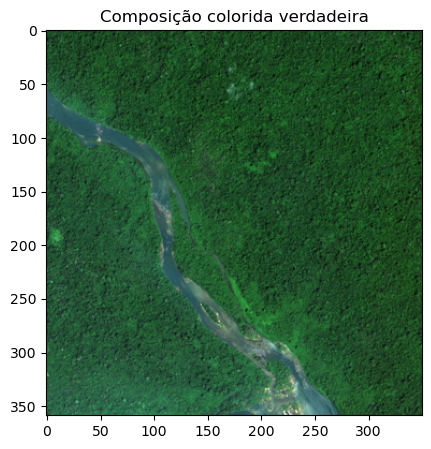

In [78]:
# definimos os números de linhas/colunas
# a partir de alguma matriz da imagem original
linhas = blue_n.shape[0]
colunas = blue_n.shape[1]

# para criar uma visualização em cores
# verdadeiras, podemos associar as bandas
# do RapidEye 3 - Red, 2 - Green, 1 - Blue
# para isso criamos uma matriz com 3 dimensões
# (3 x linhas x colunas)
array_rgb = np.zeros((linhas, colunas, 3))

# veja que, para visualizar corretamente,
# precisaremos dividir as matrizes pelo
# maior valor, para obtermos uma matriz
# com valores normalizados entre 0.0 e 1.0
array_rgb[:, :, 0] = red_n / red_n.max()
array_rgb[:, :, 1] = green_n / green_n.max()
array_rgb[:, :, 2] = blue_n / blue_n.max()

plt.figure(figsize=(20, 5))
plt.imshow(array_rgb)
plt.title('Composição colorida verdadeira');

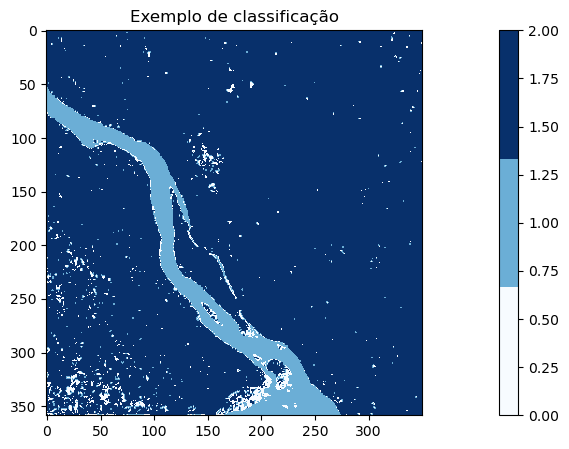

In [79]:
# definição de algumas constantes (empíricas)
delta = 0.0000000001
limiar_ndwi = 0.0
limiar_ndvi = 0.5


# vamos alterar o tipo de uma das matrizes
# de bandas para float, para que os cálculos
# dos índices fiquem adequados
nir_n = nir_n.astype(float)

# cálculo das matrizes com os índices
ndwi = (green_n - nir_n) / (green_n + nir_n + delta)
ndvi = (nir_n - red_n) / (nir_n + red_n + delta)

# criação de classificações simples
classificacao = np.zeros_like(ndwi)
classificacao = np.where(ndwi > limiar_ndwi, 1, np.where(ndvi > limiar_ndvi, 2, 0))

plt.figure(figsize=(20, 5))
colormap_3classes = plt.get_cmap('Blues', 3)
plt.imshow(classificacao, cmap=colormap_3classes)
plt.colorbar()
plt.title('Exemplo de classificação');

In [ ]:
# importar bibliotecas
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

# informar o uso de exceções
gdal.UseExceptions()

# abrir o dataset da imagem RapidEye, com 5 bandas
# (ao usar o colab, lembre-se de fazer o upload na aba de arquivos)
dataset = gdal.Open("patches_rgb/CB4A_WFI_L4_DN_1_RGB_patch.tif", gdal.GA_ReadOnly)

# obter os objetos com as informações das bandas
banda_blue = dataset.GetRasterBand(1)
banda_green = dataset.GetRasterBand(2)
banda_red = dataset.GetRasterBand(3)
# banda_rededge = dataset.GetRasterBand(4)
# banda_nir = dataset.GetRasterBand(5)

# imprimir informações de máximos/mínimos
# valores dos pixels de cada banda
print(banda_blue.ComputeRasterMinMax())
print(banda_green.ComputeRasterMinMax())
print(banda_red.ComputeRasterMinMax())
# print(banda_rededge.ComputeRasterMinMax())
# print(banda_nir.ComputeRasterMinMax())



# a função GetHistogram precisa de intervalos
# mínimos e máximos de pixels para cada banda (min/max)
# e também a informação de divisões do gráfico (buckets)
plt.figure(figsize=(20, 5))
plt.plot(banda_blue.GetHistogram(min=0, max=1, buckets=100), 'b', label='Banda 1 - Blue')
plt.plot(banda_green.GetHistogram(min=0, max=1, buckets=100), 'g', label='Banda 2 - Green')
plt.plot(banda_red.GetHistogram(min=0, max=1, buckets=100), 'r', label='Banda 3 - Red')
# plt.plot(banda_rededge.GetHistogram(min=0, max=25000, buckets=100), 'orange', label='Banda 4 - Red-Edge')
# plt.plot(banda_nir.GetHistogram(min=0, max=25000, buckets=100), 'cyan', label='Banda 5 - NIR')
plt.grid()
plt.legend()

In [ ]:
# importar bibliotecas
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

# informar o uso de exceções
gdal.UseExceptions()

# abrir o dataset da imagem RapidEye, com 5 bandas
# (ao usar o colab, lembre-se de fazer o upload na aba de arquivos)
dataset = gdal.Open("patches_rgb/CB4A_WPM_L4_DN_1_RGB_patch.tif", gdal.GA_ReadOnly)

# obter os objetos com as informações das bandas
banda_blue = dataset.GetRasterBand(1)
banda_green = dataset.GetRasterBand(2)
banda_red = dataset.GetRasterBand(3)
# banda_rededge = dataset.GetRasterBand(4)
# banda_nir = dataset.GetRasterBand(5)

# imprimir informações de máximos/mínimos
# valores dos pixels de cada banda
print(banda_blue.ComputeRasterMinMax())
print(banda_green.ComputeRasterMinMax())
print(banda_red.ComputeRasterMinMax())
# print(banda_rededge.ComputeRasterMinMax())
# print(banda_nir.ComputeRasterMinMax())



# a função GetHistogram precisa de intervalos
# mínimos e máximos de pixels para cada banda (min/max)
# e também a informação de divisões do gráfico (buckets)
plt.figure(figsize=(20, 5))
plt.plot(banda_blue.GetHistogram(min=0, max=1, buckets=50), 'b', label='Banda 1 - Blue')
plt.plot(banda_green.GetHistogram(min=0, max=1, buckets=50), 'g', label='Banda 2 - Green')
plt.plot(banda_red.GetHistogram(min=0, max=1, buckets=50), 'r', label='Banda 3 - Red')
# plt.plot(banda_rededge.GetHistogram(min=0, max=25000, buckets=100), 'orange', label='Banda 4 - Red-Edge')
# plt.plot(banda_nir.GetHistogram(min=0, max=25000, buckets=100), 'cyan', label='Banda 5 - NIR')
plt.grid()
plt.legend()

# Ver sobre skewness and kurtosis

In [ ]:
# obter as matrizes de pixels de cada banda
blue = banda_blue.ReadAsArray()
green = banda_green.ReadAsArray()
red = banda_red.ReadAsArray()

# combinamos GDAL e Matplotlib para
# visualizar as bandas individualmente
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.imshow(blue, cmap='gray')
plt.title('Banda 1 - Blue')
plt.subplot(132)
plt.imshow(green, cmap='gray')
plt.title('Banda 2 - Green')
plt.subplot(133)
plt.imshow(red, cmap='gray')
plt.title('Banda 3 - Red')


In [ ]:
# definimos os números de linhas/colunas
# a partir de alguma matriz da imagem original
linhas = blue.shape[0]
colunas = blue.shape[1]

# para criar uma visualização em cores
# verdadeiras, podemos associar as bandas
# do RapidEye 3 - Red, 2 - Green, 1 - Blue
# para isso criamos uma matriz com 3 dimensões
# (3 x linhas x colunas)
array_rgb = np.zeros((linhas, colunas, 3))

# veja que, para visualizar corretamente,
# precisaremos dividir as matrizes pelo
# maior valor, para obtermos uma matriz
# com valores normalizados entre 0.0 e 1.0
array_rgb[:, :, 0] = red / red.max()
array_rgb[:, :, 1] = green / green.max()
array_rgb[:, :, 2] = blue / blue.max()

plt.figure(figsize=(20, 20))
plt.imshow(array_rgb)
plt.title('Composição colorida verdadeira');

In [ ]:

import rasterio
import matplotlib.pyplot as plt
import numpy as np

def normalize(band):
    """Normaliza uma banda para o intervalo [0, 1]."""
    return (band - band.min()) / (band.max() - band.min() + 1e-8)

def carregar_rgb(hrefs_rgb):
    """Carrega e normaliza as 3 bandas RGB a partir de URLs."""
    bandas = []
    for href in hrefs_rgb:
        with rasterio.open(href) as src:
            bandas.append(normalize(src.read(1).astype('float32')))
    return np.stack(bandas, axis=-1)

# Mapeamento de bandas RGB por coleção
bandas_rgb = {
    'CB4A-WFI-L4-DN-1': ['BAND15', 'BAND14', 'BAND13'],  # R, G, B
    'CB4A-MUX-L4-DN-1': ['BAND7', 'BAND6', 'BAND5'],     # R, G, B
    'CB4A-WPM-L4-DN-1': ['BAND3', 'BAND2', 'BAND1']      # R, G, B
}

# Visualizar todas as coleções

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), dpi=300)

# Iterar sobre coleções e eixos
for ax, (colecao, bandas) in zip(axes, bandas_rgb.items()):
    hrefs = [assets_por_colecao[colecao][b] for b in bandas]
    rgb = carregar_rgb(hrefs)

    ax.imshow(rgb)
    ax.set_title(f"RGB - {colecao}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()




# blue_asset_wfi

# with rasterio.open(green_asset_wfi) as banda:
#     banda4 = banda.read(1)

# print(banda4)

Agora vamos procurar por datas em que haja imagens disponíveis dos três sensores (WFI, MUX, WPM), dentro do período de 01 de janeiro de 2009 a 13 de maio de 2025. Para isso, será utilizado o método de busca search do objeto catalogo. Este método irá utilizar o endpoint /search do serviço STAC do BDC.

Vamos atravessar o conjunto de itens retornados usando o método `items()`. No código abaixo, são listados os três primeiros itens (ou cenas) disponíveis:

In [ ]:
item = next(item_search.items())
item

# Agroa vamos usando a biblioteca RasterIO para manipular as imagens
<hr style="border:1px solid #0077b9;">

In [ ]:
import rasterio


In [ ]:
import xarray as xr
import rioxarray as rxr

# URLs das bandas MUX
base_url = "https://data.inpe.br/bdc/data/CB4A-WFI-L4-DN/2024_11/CBERS_4A_WFI_RAW_2024_11_28.13_54_49_ETC2/215_124_0/4_BC_UTM_WGS84/CBERS_4A_WFI_20241128_215_124_L4_{}"

band_files = ["BAND13", "BAND14", "BAND15", "BAND16"]
band_urls = [base_url.format(b + ".tif") for b in band_files]

# Abrir e empilhar
bands = [rxr.open_rasterio(url, masked=True).squeeze("band") for url in band_urls]
stacked_mux = xr.concat(bands, dim="band")
stacked_mux = stacked_mux.assign_coords(band=["B5", "B6", "B7", "B8"])

stacked_mux.plot.imshow(x="x", y="y", col="band", col_wrap=2, cmap="gray")


In [ ]:
# blue_asset_wfi = resultados['CB4A-WFI-L4-DN-1'][0].assets['BAND13'].href
# green_asset_wfi = resultados['CB4A-WFI-L4-DN-1'][0].assets['BAND14'].href
# red_asset_wfi = resultados['CB4A-WFI-L4-DN-1'][0].assets['BAND15'].href
# nir_asset_wfi = resultados['CB4A-WFI-L4-DN-1'][0].assets['BAND16'].href

with rasterio.open(blue_asset_wfi) as banda:
    banda13 = banda.read(1)

with rasterio.open(green_asset_wfi) as banda:
    banda14 = banda.read(1)

with rasterio.open(red_asset_wfi) as banda:
    banda15 = banda.read(1)


with rasterio.open(nir_asset_wfi) as banda:
    banda16 = banda.read(1)

In [ ]:
print(banda13.shape)
print(banda14.shape)
print(banda15.shape)
print(banda16.shape)

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 4))
ax1.imshow(banda13, cmap='gray')
ax2.imshow(banda14, cmap='gray')
ax3.imshow(banda15, cmap='gray')

In [ ]:
import numpy

In [ ]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [ ]:
rgb = numpy.dstack((normalize(banda13), normalize(banda14), normalize(banda15)))
plt.imshow(rgb)

In [ ]:


# Consulta às coleções CBERS-4
collections = ['CB2B-WFI-L2-DN-1', 'CB4A-MUX-L4-DN-1', 'CB4A-WPM-L2-DN-1']
items = {}

for collection in collections:
    search = catalogo.search(
        collections=[collection],
        bbox=aoi_bounds,
        # datetime="2019-08-01/2019-08-31",  # período de interesse
        max_items=5
    )
    items[collection] = list(search.get_items())

# Verificar número de cenas retornadas
for k, v in items.items():
    print(f"{k}: {len(v)} cenas")

# Escolher uma cena de cada sensor
selected_items = {
    sensor: items[sensor][0] for sensor in collections if len(items[sensor]) > 0
}




# Empilhar bandas como xarray
stacked = {}
for sensor, item in selected_items.items():
    stacked[sensor] = stackstac.stack(item, resolution=30, epsg=4326)


for sensor, data in stacked.items():
    x_size = data['x'].size
    y_size = data['y'].size
    print(f"{sensor} -> shape: {data.shape}, x: {x_size}, y: {y_size}")

    if x_size > 1 and y_size > 1:
        data.isel(band=0).squeeze().plot.imshow()
        plt.title(f"{sensor} - Banda 1 (imagem completa)")
        plt.show()
    # else:
    #     print(f"⚠️ Dados insuficientes para plotar {sensor} (apenas 1x1 pixel)")






In [ ]:
for sensor, data in stacked.items():
    print(f"{sensor} -> shape: {data.shape}, dims: {data.dims}")



for sensor, data in stacked.items():
    print(f"{sensor} -> shape: {data.shape}")
    # Mostrar a primeira banda
    data.isel(band=0).squeeze().plot.imshow()
    plt.title(f"{sensor} - Banda 1")
    plt.show()


# Exportar patches de forma simplificada
output_dir = "patches"
os.makedirs(output_dir, exist_ok=True)

for sensor, data in stacked.items():
    patch = data.isel(band=slice(0, 4)).isel(x=slice(0, 256), y=slice(0, 256))
    patch.rio.to_raster(f"{output_dir}/{sensor}_patch.tif")

# AWS STAC Catalogs
<hr style="border:1px solid #0077b9;">

<p>For Sentinel-2 EO Data Cubes, use <a href="https://bdc-sentinel-2.s3.us-west-2.amazonaws.com/catalog.json">https://bdc-sentinel-2.s3.us-west-2.amazonaws.com/catalog.json</a></p>
<p>For CBERS EO Data Cubes, use <a href="https://bdc-cbers.s3.us-west-2.amazonaws.com/catalog.json">https://bdc-cbers.s3.us-west-2.amazonaws.com/catalog.json</a></p>

In this notebook, we are going to use `Sentinel-2`.


# STAC Client API
<hr style="border:1px solid #0077b9;">

For running the examples in this Jupyter Notebook you will need to install the [pystac-client](https://pystac-client.readthedocs.io/en/latest/). To install it from PyPI using `pip`, use the following command:

In [ ]:
!pip install pystac-client==0.3.2

In [ ]:
!pip install rasterio

In order to access the funcionalities of the client API, you should import the `pystac_client` package, as follows:

In [ ]:
import pystac_client

After that, you can check the installed `pystac_client` package version:

In [ ]:
pystac_client.__version__

Then, create a `pystac_client.Client` object attached to the Brazil Data Cube' STAC service:

In [ ]:
service = pystac_client.Client.open('https://bdc-sentinel-2.s3.us-west-2.amazonaws.com/catalog.json')
service

# Listing the Available Data Products
<hr style="border:1px solid #0077b9;">

In the Jupyter environment, the `STAC` object will list the available image and data cube collections from the service:

In [ ]:
for collection in service.get_collections():
    print(collection)

## Retrieving the Metadata of a Data Product
<hr style="border:1px solid #0077b9;">

The `collection` method returns information about a given image or data cube collection identified by its name. In this example we are retrieving information about the datacube collection `S2-16D-1`:

In [ ]:
collection = service.get_collection('S2-16D-1')
collection.to_dict()

## Retrieving Collection Items
<hr style="border:1px solid #0077b9;">

Since we are using a `static` catalog, you cannot query for items using spatial filter. Instead, you must either traverse entire catalog using `get_all_items()` or query by identifier `.get_item(itemId, recursive=True)`. Keep in mind that it will traverse the entire catalog and may took too long time to finish. We recommend you to use [`stac-browser`](https://radiantearth.github.io/stac-browser/#/external/bdc-sentinel-2.s3.us-west-2.amazonaws.com/catalog.json) to navigate to the catalog and then look for the region of interest.
In the below example, we are going to use the following `s2-16d/v1/079/085/2018/09` which represents an region on Brazilian Amazon Biome.


In [ ]:
# Display an item only
catalog_201809 = pystac_client.Client.open('https://bdc-sentinel-2.s3.us-west-2.amazonaws.com/s2-16d/v1/079/085/2018/09/catalog.json')

for item in catalog_201809.get_all_items():
    print(item)

In [ ]:
items = list(catalog_201809.get_all_items())
item = items[0]
item

## Assets
<hr style="border:1px solid #0077b9;">

The assets with the links to the images, thumbnails or specific metadata files, can be accessed through the property `assets` (from a given item):

In [ ]:
assets = item.assets

Then, from the assets it is possible to traverse or access individual elements:

In [ ]:
for k in assets.keys():
    print(k)

The metadata related to the Sentinel 2A/2B blue band is available under the dictionary key `B02`:

In [ ]:
blue_asset = assets['B02']
blue_asset

To iterate in the item's assets, use the following pattern:

In [ ]:
for asset in assets.values():
    print(asset)

## Using RasterIO and NumPy
<hr style="border:1px solid #0077b9;">

The `rasterio` library can be used to read image files from the Brazil Data Cube' service on-the-fly and then to create `NumPy` arrays. The `read` method of an `Item` can be used to perform the reading and array creation:

In [ ]:
import rasterio

In [ ]:
with rasterio.open(assets['B08'].href) as nir_ds:
    nir = nir_ds.read(1)

<div style="text-align: justify;  margin-left: 15%; margin-right: 15%; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 5px;">
    <b>Note:</b> If there are errors because of your pyproj version, you can run the code below as specified in <a  href="https://rasterio.readthedocs.io/en/latest/faq.html#why-can-t-rasterio-find-proj-db-rasterio-from-pypi-versions-1-2-0" target="_blank">rasterio documentation</a> and try again:

       import os
       del os.environ['PROJ_LIB']
</div>

In [ ]:
nir

The next cell code import the `Window` class from the `rasterio` library in order to retrieve a subset of an image and then create an array:

In [ ]:
from rasterio.windows import Window

We have prepared a basic function `read()`to read raster windows as [`numpy.ma.masked_array`](https://numpy.org/doc/stable/reference/maskedarray.generic.html).

In [ ]:
def read(uri: str, window: Window, masked: bool = True):
    """Read raster window as numpy.ma.masked_array."""
    with rasterio.open(uri) as ds:
        return ds.read(1, window=window, masked=masked)

We can specify a subset of the image file (window or chunck) to be read. Let's read a range that starts on pixel (0, 0) with 500 x 500 and column 0 to column 500, for the spectral bands `red`, `green` and `blue`:

In [ ]:
red = read(assets['B04'].href, window=Window(0, 0, 500, 500)) # Window(col_off, row_off, width, height)

In [ ]:
green = read(assets['B03'].href, window=Window(0, 0, 500, 500))

In [ ]:
blue = read(assets['B02'].href, window=Window(0, 0, 500, 500))

In [ ]:
blue

## Using Matplotlib to Visualize Images
<hr style="border:1px solid #0077b9;">

The `Matplotlib` cab be used to plot the arrays read in the last section:

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 4))
ax1.imshow(red, cmap='gray')
ax2.imshow(green, cmap='gray')
ax3.imshow(blue, cmap='gray')

Using `Numpy` we can stack the previous arrays and use `Matplotlib` to plot a color image, but first we need to normalize their values:

In [ ]:
import numpy

In [ ]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [ ]:
rgb = numpy.dstack((normalize(red), normalize(green), normalize(blue)))
plt.imshow(rgb)

# Retrieving Image Files
<hr style="border:1px solid #0077b9;">

The file related to an asset can be retrieved through the `download` method. The cell code below shows ho to download the image file associated to the asset into a folder named `img`:

In [ ]:
import os
from urllib.parse import urlparse

import requests
from pystac import Asset
from tqdm import tqdm

def download(asset: Asset, directory: str = None, chunk_size: int = 1024 * 16, **request_options) -> str:
    """Smart download STAC Item asset.

    This method uses a checksum validation and a progress bar to monitor download status.
    """
    if directory is None:
        directory = ''

    response = requests.get(asset.href, stream=True, **request_options)
    output_file = os.path.join(directory, urlparse(asset.href)[2].split('/')[-1])
    os.makedirs(directory, exist_ok=True)
    total_bytes = int(response.headers.get('content-length', 0))
    with tqdm.wrapattr(open(output_file, 'wb'), 'write', miniters=1, total=total_bytes, desc=os.path.basename(output_file)) as fout:
        for chunk in response.iter_content(chunk_size=chunk_size):
            fout.write(chunk)

In [ ]:
download(assets['B08'], 'img')

In order to download all files related to an item, iterate over assets and download each one as following:

In [ ]:
for asset in assets.values():
    download(asset, 'images')

Note that the URL for a given asset can be retrieved by the property `href`:

In [ ]:
blue_asset.href

# References
<hr style="border:1px solid #0077b9;">

- [Spatio Temporal Asset Catalog Specification](https://stacspec.org/)


- [Python Client Library for STAC Service](https://pystac-client.readthedocs.io/en/latest/)

# See also the following Jupyter Notebooks
<hr style="border:1px solid #0077b9;">

* [Image processing on images obtained through STAC](./stac-image-processing.ipynb)


* [NDVI calculation on images obtained through STAC](./stac-introduction.ipynb)